In [1]:
from argparse import Namespace
from run_capsule import *

In [2]:
# Create Namespace object with default arguments
args = Namespace(
    source_pattern=r"/data/nwb/*.nwb",
    output_dir="/results/",
    fiber_path="/data/fiber_raw_data",
    dff_methods=["poly", ],  # "exp", "bright"],
    no_qc=False
)

In [3]:
    fiber_path = Path(args.fiber_path)

    # Load subject data
    subject_json_path = fiber_path / "subject.json"
    with open(subject_json_path, "r") as f:
        subject_data = json.load(f)

    # Grab the subject_id and times for logging
    subject_id = subject_data.get("subject_id", None)

    # Raise an error if subject_id is None
    if subject_id is None:
        logging.info("No subject_id in subject file")
        raise ValueError("subject_id is missing from the subject_data.")

    # Load data description
    data_description_path = fiber_path / "data_description.json"
    with open(data_description_path, "r") as f:
        data_description = json.load(f)

    asset_name = data_description.get("name", None)

    log.setup_logging(
        "aind-fip-dff",
        subject_id=subject_id,
        asset_name=asset_name,
    )

    # Create the destination directory if it doesn't exist
    os.makedirs(args.output_dir, exist_ok=True)

    # Find all files matching the source pattern
    source_paths = glob.glob(args.source_pattern)

Could not connect to boto3. Logging to console only
Starting


In [5]:
    # Copy each matching file to the destination directory
    for source_path in source_paths:
        destination_path = os.path.join(
            args.output_dir, "nwb", os.path.basename(source_path)
        )
        shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
        # Update path to the NWB file within the copied directory
        nwb_file_path = destination_path
        if os.path.isdir(os.path.join(args.fiber_path, "FIP")) or os.path.isdir(
            os.path.join(args.fiber_path, "fib")
        ):
            # Print the path to ensure correctness
            logging.info(f"Processing NWB file: {nwb_file_path}")

            with NWBZarrIO(path=str(nwb_file_path), mode="r+") as io:
                nwb_file = io.read()
                # convert nwb to dataframe
                df_from_nwb = nwb_utils.nwb_to_dataframe(nwb_file)
                # add the session column
                filename = os.path.basename(nwb_file_path)
                if "behavior" in filename:
                    session_name = filename.split(".")[0]
                    session_name = session_name.split("behavior_")[1]
                else:
                    session_name = filename.split(".")[0]
                    session_name = session_name.split("FIP_")[1]

                df_from_nwb.insert(0, "session", session_name)

                # now pass the dataframe through the preprocessing function:
                df_fip_pp, df_PP_params, coeffs = batch_processing(
                    df_from_nwb, args.dff_methods
                )
                
                methods = df_fip_pp.preprocess.unique()
                for method in methods:
                    for signal, suffix in (
                        ("dFF", f"_dff-{method}"),
                        ("motion_corrected", f"_dff-{method}_mc-iso-IRLS"),
                    ):
                        # format the processed traces as dict for conversion to nwb
                        dict_from_df = nwb_utils.split_fip_traces(
                            df_fip_pp[df_fip_pp.preprocess == method], signal=signal
                        )
                        # and add them to the original nwb
                        nwb_file = nwb_utils.attach_dict_fip(
                            nwb_file, dict_from_df, suffix
                        )

                io.write(nwb_file)
                logging.info(
                    "Successfully updated the nwb with preprocessed data"
                    f" using methods {methods}"
                )

Processing NWB file: /results/nwb/behavior_746345_2024-11-27_09-28-51.nwb
/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/root/capsule/code/utils/preprocess.py:29: RuntimeWarning: invalid value encountered in divide
  tc_dFoF = tc / tc_base
Successfully updated the nwb with preprocessed data using methods ['poly']


In [6]:
df_fip_pp

,session,time_fip,channel,fiber_number,signal,dFF,preprocess,F0,motion_corrected,filtered
0,746345_2024-11-27_09-28-51,1.710622e+06,G,0,1333.554404,0.244804,poly,1150.209072,1223.165818,188924.268814
1,746345_2024-11-27_09-28-51,1.710622e+06,G,0,1328.663212,0.244804,poly,1150.209072,733.149150,188647.042454
2,746345_2024-11-27_09-28-51,1.710622e+06,G,0,1340.849741,0.244804,poly,1150.209072,1514.437044,188366.142145
3,746345_2024-11-27_09-28-51,1.710622e+06,G,0,1317.886010,0.244804,poly,1150.209072,982.683179,188083.181897
4,746345_2024-11-27_09-28-51,1.710622e+06,G,0,1323.025907,0.244804,poly,1150.209072,1212.637321,187799.897008
...,...,...,...,...,...,...,...,...,...,...
1223911,746345_2024-11-27_09-28-51,1.715721e+06,R,3,753.899857,-0.007539,poly,763.038783,753.899857,0.000000
1223912,746345_2024-11-27_09-28-51,1.715721e+06,R,3,756.280401,-0.004401,poly,763.038678,756.280401,0.000000
1223913,746345_2024-11-27_09-28-51,1.715721e+06,R,3,774.317597,0.019370,poly,763.038573,774.317597,0.000000
1223914,746345_2024-11-27_09-28-51,1.715721e+06,R,3,750.695279,-0.011762,poly,763.038469,750.695279,0.000000


In [7]:
coeffs

[array([60.27904456,  1.        ,  4.37249071]),
 array([1.35894683, 1.        , 0.        ]),
 array([0.33104864, 1.        , 0.59643784]),
 array([nan, nan, nan])]

In [11]:
import pandas as pd

In [12]:
channels = df_from_nwb.channel.unique()
fibers = df_from_nwb.fiber_number.unique()

In [15]:
def plot_dff(
    nwb_file: pynwb.NWBFile,
    df_fip_pp: pd.DataFrame,
    fiber: str,
    channels: list[str],
    method: str,
    fig_path: str,
):
    """Plot raw and dF/F photometry traces for multiple channels.

    Parameters
    ----------
    nwb_file : NWBFile
        The Neurodata Without Borders (NWB) file containing photometry signal traces
        and their associated metadata.
    df_fip_pp : pd.DataFrame
        The dataframe with the preprocessed FIP data containing F, dF/F and F0 traces.
    fiber : str
        The name of the fiber for which the signals should be plotted.
    channels : list of str
        A list of channel names to be plotted (e.g., ['G', 'R', 'Iso']).
    method : str
        The name of the preprocessing method used ("poly", "exp", or "bright").
    fig_path : str
        The path where the generated plot will be saved.
    """
    fig, ax = plt.subplots(2*len(channels), 1, figsize=(12, 2*len(channels)), sharex=True)
    for c, ch in enumerate(sorted(channels)):
        r = nwb_file.acquisition[ch + f"_{fiber}"]
        t, raw = r.timestamps[:], r.data[:]
        t -= t[0]
        df = df_fip_pp[(df_fip_pp.channel==ch) & (df_fip_pp.fiber_number==fiber) & (df_fip_pp.preprocess==method)]
        dff = df.dFF.values
        F0 = df.F0.values
        if ~np.isnan(t).all():
            for i in (0,1):
                a = ax[2*c+i]
                a.plot(t, (raw, dff * 100)[i], label=(("raw ", r"$\Delta$F/F ")[i] + ch),
                            # more color-blind-friendly g, b, and r
                            c={"G": "#009E73", "Iso": "#0072B2", "R": "#D55E00"}.get(
                                ch, f"C{c}"
                            ))
                if i == 0:
                    a.plot(t, F0, label=r"fitted F$_0$", c="#F0E442")
                else:
                    a.axhline(0, c='k', ls='--')
                a.legend(loc=(.01,.77), ncol=2-i, borderpad=0.05).get_frame().set_linewidth(0.0)
                a.set_ylabel(("F [a.u.]", r"$\Delta$F/F [%]")[i])
                
    tmin, tmax = np.nanmin(t), np.nanmax(t)
    ax[i].set_xlim(tmin - (tmax - tmin) / 100, tmax + (tmax - tmin) / 100)
    plt.suptitle(f"$\\bf{{\Delta F/F_0}}$  Method: {method},  ROI: {fiber}", y=1)
    plt.xlabel("Time [" + r.unit + "]")
    plt.tight_layout(pad=0.2, h_pad=0)

    os.makedirs(fig_path, exist_ok=True)
    fig_file = os.path.join(fig_path, f"ROI{fiber}_{method}.png")
    plt.savefig(fig_file, dpi=300)
    return fig_file

'./ROI0_poly.png'

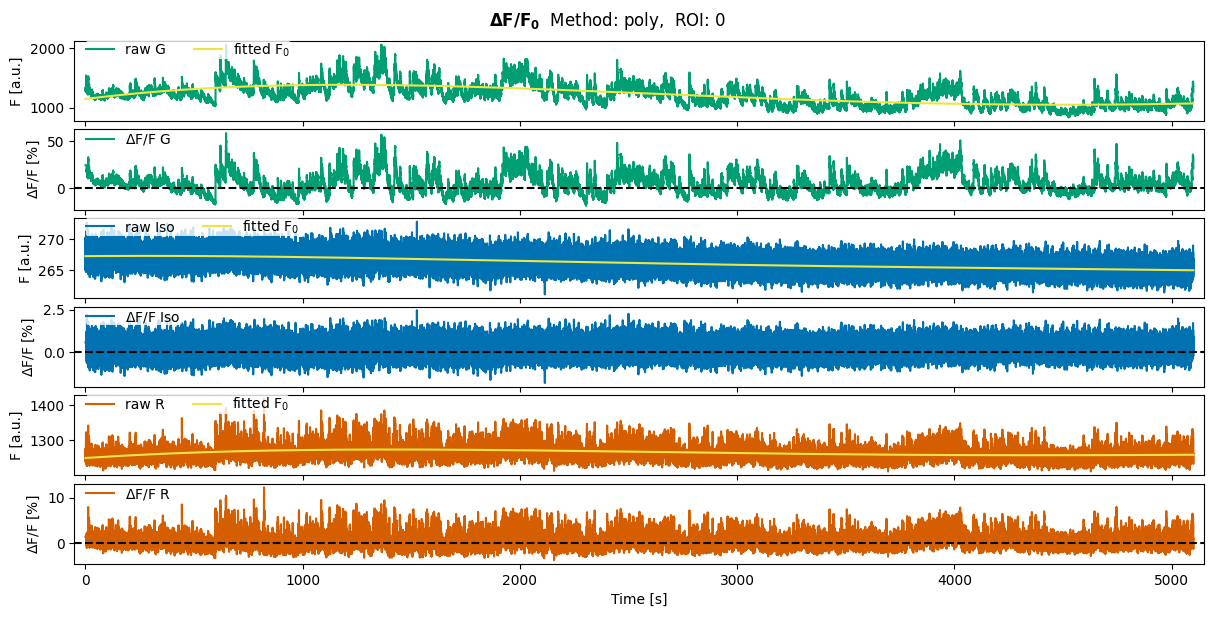

In [16]:
plot_dff(nwb_file, df_fip_pp, "0", channels, method, "./")

In [26]:
df = df_fip_pp[(df_fip_pp.channel=="G") & (df_fip_pp.fiber_number=="0") & (df_fip_pp.preprocess==method)]
df.time_fip

0         1.710622e+06
1         1.710622e+06
2         1.710622e+06
3         1.710622e+06
4         1.710622e+06
              ...     
101988    1.715721e+06
101989    1.715721e+06
101990    1.715721e+06
101991    1.715721e+06
101992    1.715721e+06
Name: time_fip, Length: 101993, dtype: float64

In [27]:
nwb_file.acquisition["G" + f"_{0}"].timestamps[:]

array([1710621.5126784, 1710621.562464 , 1710621.6124928, ...,
       1715721.2095872, 1715721.2598144, 1715721.3093824], shape=(101993,))

In [31]:
np.min(np.diff(df.time_fip))

np.float64(0.03320319997146726)

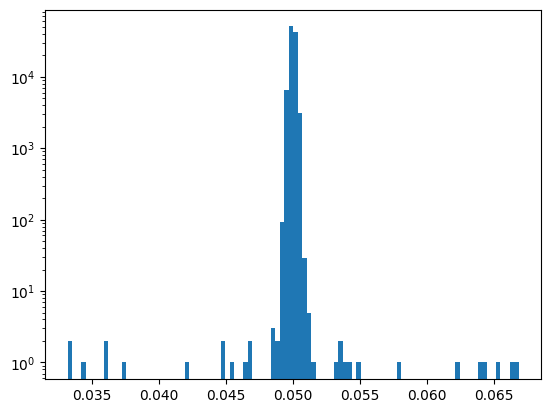

In [32]:
plt.hist(np.diff(df.time_fip), 100, log=True);

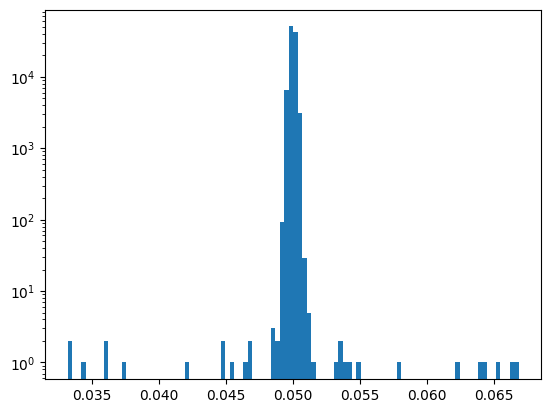

In [33]:
plt.hist(np.diff(nwb_file.acquisition["G" + f"_{0}"].timestamps[:]), 100, log=True);

In [54]:
def plot_dff(
    df_fip_pp: pd.DataFrame,
    fiber: str,
    channels: list[str],
    method: str,
    fig_path: str,
):
    """Plot raw and dF/F photometry traces for multiple channels.

    Parameters
    ----------
    df_fip_pp : pd.DataFrame
        The dataframe with the preprocessed FIP data containing F, dF/F and F0 traces.
    fiber : str
        The name of the fiber for which the signals should be plotted.
    channels : list of str
        A list of channel names to be plotted (e.g., ['G', 'R', 'Iso']).
    method : str
        The name of the preprocessing method used ("poly", "exp", or "bright").
    fig_path : str
        The path where the generated plot will be saved.
    """
    fig, ax = plt.subplots(2*len(channels), 1, figsize=(12, 2*len(channels)), sharex=True)
    for c, ch in enumerate(sorted(channels)):
        df = df_fip_pp[(df_fip_pp.channel==ch) & (df_fip_pp_nwb.fiber_number==fiber) & (df_fip_pp_nwb.preprocess==method)]
        t = df.time_fip.values
        t -= t[0]
        if ~np.isnan(t).all():
            for i in (0,1):
                a = ax[2*c+i]
                a.plot(t, (df.signal, df.dFF * 100)[i], label=(("raw ", r"$\Delta$F/F ")[i] + ch),
                            # more color-blind-friendly g, b, and r
                            c={"G": "#009E73", "Iso": "#0072B2", "R": "#D55E00"}.get(
                                ch, f"C{c}"
                            ))
                if i == 0:
                    a.plot(t, df.F0, label=r"fitted F$_0$", c="#F0E442")
                else:
                    a.axhline(0, c='k', ls='--')
                a.legend(loc=(.01,.77), ncol=2-i, borderpad=0.05).get_frame().set_linewidth(0.0)
                a.set_ylabel(("F [a.u.]", r"$\Delta$F/F [%]")[i])
                
    tmin, tmax = np.nanmin(t), np.nanmax(t)
    ax[i].set_xlim(tmin - (tmax - tmin) / 100, tmax + (tmax - tmin) / 100)
    plt.suptitle(f"$\\bf{{\Delta F/F_0}}$  Method: {method},  ROI: {fiber}", y=1)
    plt.xlabel("Time [s]")
    plt.tight_layout(pad=0.2, h_pad=0)

    os.makedirs(fig_path, exist_ok=True)
    fig_file = os.path.join(fig_path, f"ROI{fiber}_{method}.png")
    plt.savefig(fig_file, dpi=300)
    return fig_file

CPU times: user 2.45 s, sys: 3.54 ms, total: 2.45 s
Wall time: 2.47 s


'./ROI0_poly.png'

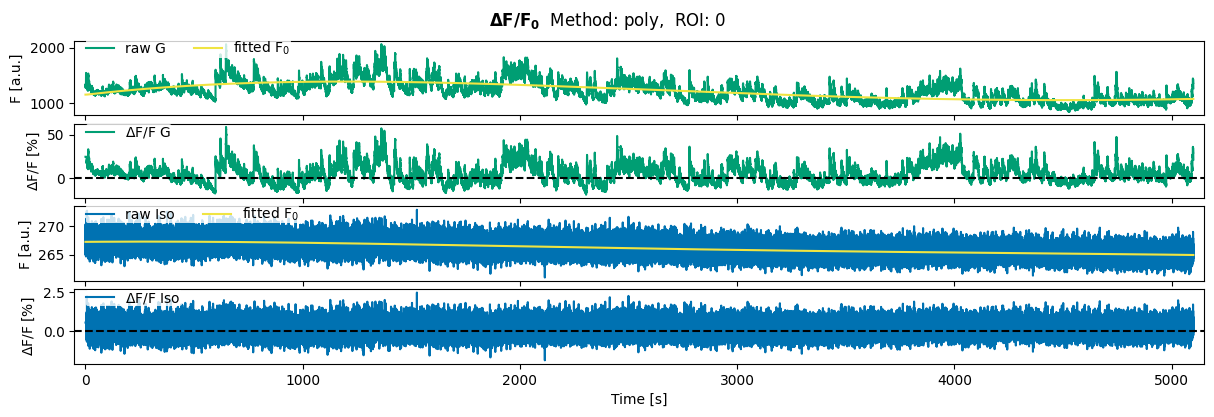

In [58]:
%%time
plot_dff(df_fip_pp, "0", channels, method, "./")

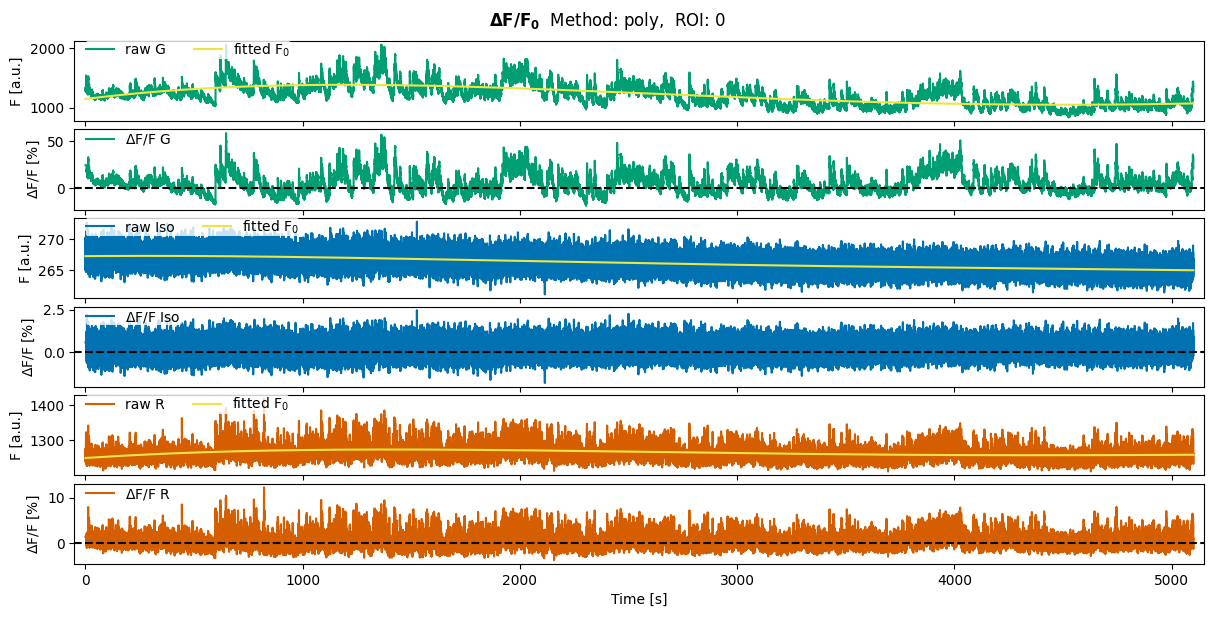

In [31]:
    fiber = "0"; method="poly"
    
    
    fig, ax = plt.subplots(2*len(channels), 1, figsize=(12, 2*len(channels)), sharex=True)
    for c, ch in enumerate(sorted(channels)):
        # r = nwb_file.acquisition[ch + f"_{fiber}"]
        # t, raw = r.timestamps[:], r.data[:]
        # t -= t[0]
        df = df_fip_pp[(df_fip_pp.channel==ch) & (df_fip_pp_nwb.fiber_number==fiber) & (df_fip_pp_nwb.preprocess==method)]
        t, raw, dFF, F0 = [df[w].time_fip.values for w in ("time_fip", "signal", "dFF", "F0")]
        t -= t[0]
        if ~np.isnan(t).all():
            for i in (0,1):
                a = ax[2*c+i]
                a.plot(t, (raw, dFF * 100)[i], label=(("raw ", r"$\Delta$F/F ")[i] + ch),
                            # more color-blind-friendly g, b, and r
                            c={"G": "#009E73", "Iso": "#0072B2", "R": "#D55E00"}.get(
                                ch, f"C{c}"
                            ))
                if i == 0:
                    a.plot(t, F0, label=r"fitted F$_0$", c="#F0E442")
                else:
                    a.axhline(0, c='k', ls='--')
                a.legend(loc=(.01,.77), ncol=2-i, borderpad=0.05).get_frame().set_linewidth(0.0)
                a.set_ylabel(("F [a.u.]", r"$\Delta$F/F [%]")[i])
                
    tmin, tmax = np.nanmin(t), np.nanmax(t)
    ax[i].set_xlim(tmin - (tmax - tmin) / 100, tmax + (tmax - tmin) / 100)
    plt.suptitle(f"$\\bf{{\Delta F/F_0}}$  Method: {method},  ROI: {fiber}", y=1)
    plt.xlabel("Time [" + r.unit + "]")
    plt.tight_layout(pad=0.2, h_pad=0)

    plt.savefig("foo.png", dpi=300)

In [ ]:
df_fip_pp_nwb

In [12]:
import pandas as pd

In [13]:
pd.isna(channels)

array([False, False, False])

In [7]:
motion_correct(df_dff_iter)

NameError: name 'df_dff_iter' is not defined

In [8]:
plt.figure(figsize=(15,3))
plt.plot(df_fip_pp_nwb[(df_fip_pp_nwb.channel=="G") & (df_fip_pp_nwb.fiber_number=="0")].signal);
plt.figure(figsize=(15,3))
plt.plot(df_fip_mc[(df_fip_pp_nwb.channel=="G") & (df_fip_pp_nwb.fiber_number=="0")].signal);

NameError: name 'df_fip_pp_nwb' is not defined

<Figure size 1500x300 with 0 Axes>

In [20]:
import pandas as pd
from utils.preprocess import *

In [21]:
df_fip = df_from_nwb

In [22]:
df_fip_pp = pd.DataFrame()
df_pp_params = pd.DataFrame()
df_mc = pd.DataFrame()

sessions = pd.unique(df_fip["session"].values)
sessions = sessions[~pd.isna(sessions)]
fiber_numbers = np.unique(df_fip["fiber_number"].values)
channels = pd.unique(df_fip["channel"])  # ['G', 'R', 'Iso']
channels = channels[~pd.isna(channels)]

In [23]:
fiber_number = "0"

for pp_name in args.dff_methods:
    if pp_name in ["poly", "exp", "bright"]:
        for i_iter, (session, fiber_number) in enumerate(
            itertools.product(sessions, fiber_numbers[:1])
        ):
            # dF/F
            df_1fiber = pd.DataFrame()
            for channel in channels:
                df_fip_iter = df_fip[
                    (df_fip["session"] == session)
                    & (df_fip["fiber_number"] == fiber_number)
                    & (df_fip["channel"] == channel)
                ].copy()
                if len(df_fip_iter) == 0:
                    continue

                NM_values = df_fip_iter["signal"].values
                NM_preprocessed, NM_fitting_params, NM_fit = chunk_processing(
                    NM_values, method=pp_name
                )
                df_fip_iter.loc[:, "signal"] = NM_preprocessed
                df_fip_iter.loc[:, "preprocess"] = pp_name
                df_fip_iter.loc[:, "F0"] = NM_fit
                df_fip_pp = pd.concat([df_fip_pp, df_fip_iter], ignore_index=True)
                df_1fiber = pd.concat([df_1fiber, df_fip_iter], ignore_index=True)

                NM_fitting_params.update(
                    {
                        "preprocess": pp_name,
                        "channel": channel,
                        "fiber_number": fiber_number,
                        "session": session,
                    }
                )
                df_pp_params_ses = pd.DataFrame(NM_fitting_params, index=[0])
                df_pp_params = pd.concat([df_pp_params, df_pp_params_ses], axis=0)

            # motion correction
            if len(df_1fiber) == 0:
                continue
            # convert to #frames x #channels
            df_dff_iter = pd.DataFrame(
                np.column_stack(
                    [
                        df_1fiber[df_1fiber["channel"] == c]["signal"].values
                        for c in channels
                    ]
                ),
                columns=channels,
            )

In [24]:
                # run motion correction
                df_mc_iter, df_filt_iter = motion_correct(df_dff_iter)

TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions

In [25]:
df_fip_iter

,session,time_fip,channel,fiber_number,signal,preprocess,F0
815944,746345_2024-11-27_09-28-51,1.710622e+06,R,0,0.013307,poly,1250.642975
815945,746345_2024-11-27_09-28-51,1.710622e+06,R,0,0.013307,poly,1250.642975
815946,746345_2024-11-27_09-28-51,1.710622e+06,R,0,0.013307,poly,1250.642975
815947,746345_2024-11-27_09-28-51,1.710622e+06,R,0,0.013307,poly,1250.642975
815948,746345_2024-11-27_09-28-51,1.710622e+06,R,0,0.013307,poly,1250.642975
...,...,...,...,...,...,...,...
917932,746345_2024-11-27_09-28-51,1.715721e+06,R,0,0.007478,poly,1259.685299
917933,746345_2024-11-27_09-28-51,1.715721e+06,R,0,-0.013825,poly,1259.685490
917934,746345_2024-11-27_09-28-51,1.715721e+06,R,0,0.010974,poly,1259.685680
917935,746345_2024-11-27_09-28-51,1.715721e+06,R,0,-0.010166,poly,1259.685870


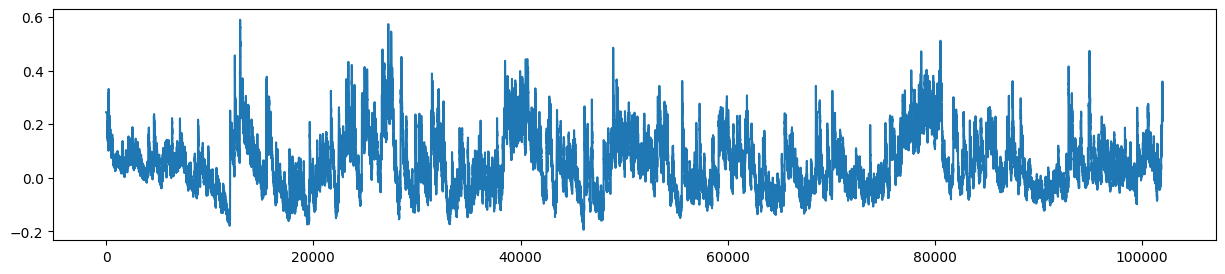

In [26]:
plt.figure(figsize=(15,3))
plt.plot(df_dff_iter.G);

In [27]:
    dff = df_dff_iter
    fs = 20
    cutoff_freq: float = 0.3
    M: RobustNorm = TukeyBiweight(3)
    """
    Perform motion correction on a fiber's dF/F traces by regressing out
    the isosbestic traces.
    Args:
        dff: pd.DataFrame
            DataFrame containing the dF/F traces of the fiber photometry signals.
        fs: float
            Sampling rate of the signal, in Hz.
        cutoff_freq: float
            Cutoff frequency of the lowpass Butterworth filter
            (that's only applied for the regression), in Hz.
        M: statsmodels.robust.norms.RobustNorm
            Robust criterion function used to downweight outliers.
            Refer to `statsmodels.robust.norms` for more details.
    Returns:
        dff_mc : pd.DataFrame
            Preprocessed fiber photometry signal with motion correction applied
            (dF/F + motion correction).
    """
    sos = butter(N=2, Wn=cutoff_freq, fs=fs, output="sos")
    dff_filt = sosfiltfilt(sos, dff, axis=0).T
    idx_iso = dff.columns.get_loc("Iso")
    motion = dff_filt[idx_iso]
    no_nans = ~np.isnan(dff_filt.sum(1))
    no_nans[idx_iso] = False  # skip regressing motion against motion, it's obviously 1
    if M is not None:
        coef = np.maximum(
            [
                RLM(d, add_constant(motion), M=M).fit().params[1:]
                for d in dff_filt[no_nans]
            ],
            0,
        )
    else:
        coef = (
            LinearRegression(fit_intercept=True, positive=True)
            .fit(motion[:, None], dff_filt[no_nans].T)
            .coef_
        )
    motions = np.full_like(dff_filt, np.nan)
    motions[no_nans] = coef * dff["Iso"].values
    motions -= motions.mean(axis=1, keepdims=True)
    dff_mc = dff - motions.T
    dff_mc["Iso"] = 0
    dff_filt[no_nans] *= coef
    dff_filt = pd.DataFrame(dff_filt.T)
    dff_filt.columns = dff_mc.columns

In [41]:
coef.ravel()

array([60.27904456,  4.37249071])

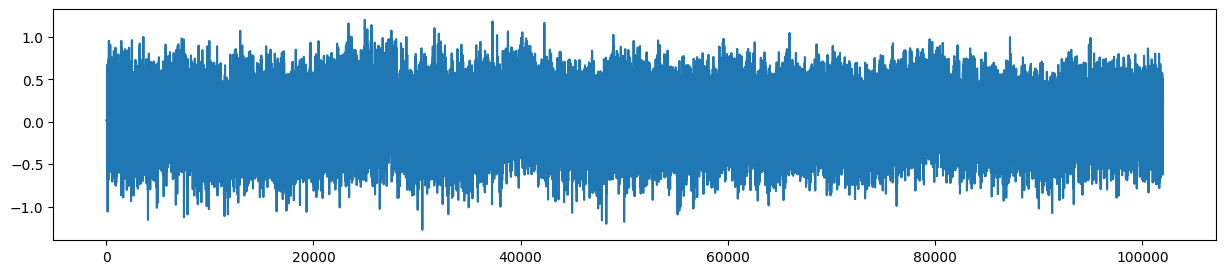

In [28]:
plt.figure(figsize=(15,3))
plt.plot(dff_mc.G);

In [29]:
dff_mc

,G,Iso,R
0,0.017761,0,-0.003162
1,0.017761,0,-0.003162
2,0.017761,0,-0.003162
3,0.017761,0,-0.003162
4,0.017761,0,-0.003162
...,...,...,...
101988,0.510902,0,0.026381
101989,0.010378,0,-0.030339
101990,0.174030,0,0.006719
101991,0.472628,0,0.007373


In [30]:
dff_mc.columns

Index(['G', 'Iso', 'R'], dtype='object')

In [31]:
dff_filt

,G,Iso,R
0,14.755860,0.005600,0.058168
1,14.755747,0.005600,0.058166
2,14.755625,0.005599,0.058163
3,14.755495,0.005599,0.058161
4,14.755357,0.005599,0.058159
...,...,...,...
101988,16.108617,0.002863,0.067999
101989,15.992052,0.002784,0.066635
101990,15.886069,0.002712,0.065468
101991,15.791276,0.002648,0.064492


In [32]:
df_mc_iter = dff_mc.melt(var_name="channel", value_name="signal")
df_mc_iter

,channel,signal
0,G,0.017761
1,G,0.017761
2,G,0.017761
3,G,0.017761
4,G,0.017761
...,...,...
305974,R,0.026381
305975,R,-0.030339
305976,R,0.006719
305977,R,0.007373


In [33]:
df_filt_iter = dff_filt.melt(var_name="channel", value_name="filtered")
df_filt_iter

,channel,filtered
0,G,14.755860
1,G,14.755747
2,G,14.755625
3,G,14.755495
4,G,14.755357
...,...,...
305974,R,0.067999
305975,R,0.066635
305976,R,0.065468
305977,R,0.064492


In [34]:
df_mc_iter.loc[:, "filtered"] = df_filt_iter.filtered

In [35]:
df_mc_iter

,channel,signal,filtered
0,G,0.017761,14.755860
1,G,0.017761,14.755747
2,G,0.017761,14.755625
3,G,0.017761,14.755495
4,G,0.017761,14.755357
...,...,...,...
305974,R,0.026381,0.067999
305975,R,-0.030339,0.066635
305976,R,0.006719,0.065468
305977,R,0.007373,0.064492


In [36]:
pd.concat([df_mc_iter, df_filt_iter])

,channel,signal,filtered
0,G,0.017761,14.755860
1,G,0.017761,14.755747
2,G,0.017761,14.755625
3,G,0.017761,14.755495
4,G,0.017761,14.755357
...,...,...,...
305974,R,NaN,0.067999
305975,R,NaN,0.066635
305976,R,NaN,0.065468
305977,R,NaN,0.064492


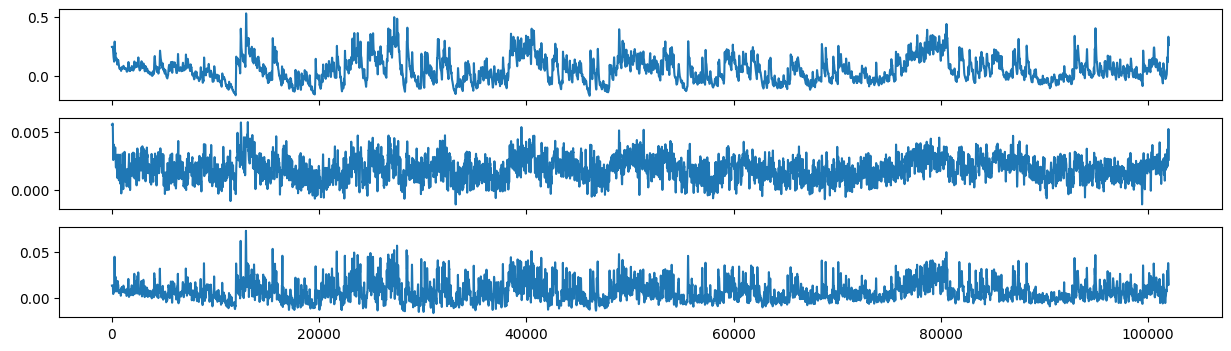

In [80]:
fig, ax = plt.subplots(3,1, figsize=(15,4), sharex=True)
for i in range(3):
    ax[i].plot(dff_filt[i]);

In [65]:
idx_iso

1

In [70]:
f = LinearRegression(fit_intercept=True, positive=True).fit(motion[:, None], dff_filt[no_nans].T)
f.coef_

array([[63.3509599],
       [ 5.2623027]])

In [71]:
f.intercept_

array([-0.06281731, -0.00276584])

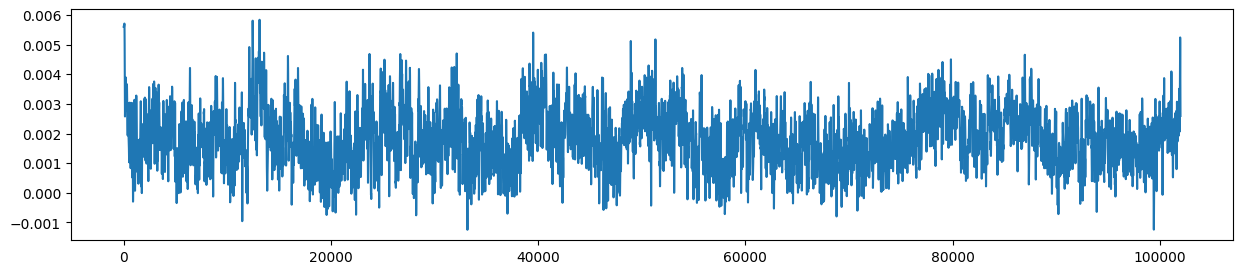

In [73]:
plt.figure(figsize=(15,3))
plt.plot(motion);

In [67]:
LinearRegression(fit_intercept=True, positive=True).fit(motion[:, None], dff_filt[no_nans].T)

array([[63.3509599],
       [ 5.2623027]])

In [69]:
LinearRegression(fit_intercept=True, positive=True).fit(dff_filt[no_nans].T, motion[:, None]).coef_

array([[0.00550845, 0.        ]])

In [68]:
dff_filt[no_nans]

array([[0.24479254, 0.24479066, 0.24478864, ..., 0.26354215, 0.26196958,
        0.26059033],
       [0.01330309, 0.0133026 , 0.01330209, ..., 0.01497281, 0.01474943,
        0.01456628]], shape=(2, 101993))